# SETUP

In [48]:
from TMclass import *
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree

from datetime import datetime as DT
from datetime import timedelta as TD

def flush_many(max_vol, vol_dataset, phi_mode, start, nbits, ndata, level, partition):
    global PHI
    
    def _new_start(start,end):
        start += TD(days=1)
        start = start.replace(hour=3,minute=0,second=0)
        if end > start:
            start = end + TD(hours=1)
        return start
    

    vol0 = max_vol[0]
    vol1 = max_vol[1]
    n0 = int(vol0 // vol_dataset * 0.99)
    n1 = int(vol1 // vol_dataset * 0.99)

    if ndata == -1:
        ndata = phi_mode.raw.n_datasets
    
    print(f'Days needed: {(ndata-n0)//n1+2}')
    kw = phi_mode.compressing(start, nbits = nbits, ndata = n0,level=level); PHI.saving(partition,**kw)
    # start += TD(days=1)
    start = _new_start(start,kw['end'])

    for i in range((ndata-n0)//n1+1):
        kw = phi_mode.compressing(start, nbits = nbits, ndata = n1,level=level); PHI.saving(partition,**kw)
        start = _new_start(start,kw['end'])

    return (phi_mode, kw)

PHI = PHI_MEMORY(DT.fromisoformat('2022-01-19T23:00:00'))

TM = {'date':[], 'tm_rate':[], 'duration':[]}
TMnew = {'date':[], 'tm_rate':[], 'duration':[]}

with open('../telem.xml') as f:
	tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = DT.fromisoformat(node.attrib.get('comment')[:-1]).date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TM['date'] += [DT.fromisoformat(node.attrib.get('comment')[:-1])]
        TM['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM['duration'] += [int(node.attrib.get('duration'))]

with open('../EFECS_M06_V00.xml') as f:
	tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TMnew['date'] += [DT.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TMnew['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TMnew['duration'] += [int(node.attrib.get('duration'))]

TM['date'] = np.asarray(TM['date'])
TM['tm_rate'] = np.asarray(TM['tm_rate'])
TM['duration'] = np.asarray(TM['duration'])

TMnew['date'] = np.asarray(TMnew['date'])
TMnew['tm_rate'] = np.asarray(TMnew['tm_rate'])
TMnew['duration'] = np.asarray(TMnew['duration'])

f = open('phi.itl','r')
lines = f.readlines()

FL = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FL['date'] += [DT.fromisoformat(temp[0][:-1])]
        FL['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FL['date'] = np.asarray(FL['date'])
FL['flush'] = np.asarray(FL['flush'])

f = open('phi.itl','r')
lines = f.readlines()

# SV = {'date':[], 'rate':[]}

# for x in lines:
#     temp = x.split(' ')
#     if 'PHI_SCI_Rate' in temp[-1]:
#         SV['date'] += [DT.fromisoformat(temp[0][:-1])]
#         SV['rate'] += [float(temp[-1][14:-2])]
#         # print(temp[0][:-1],temp[-1][19:-2])

# SV['date'] = np.asarray(SV['date'])
# SV['rate'] = np.asarray(SV['rate'])

f = open('phi_new.itl','r')
lines = f.readlines()

FLnew = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FLnew['date'] += [DT.fromisoformat(temp[0][:-1])]
        FLnew['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FLnew['date'] = np.asarray(FLnew['date'])
FLnew['flush'] = np.asarray(FLnew['flush'])



In [49]:
def synoptic(mode,t0,t1,cadence,shape,nout,nbits,i,format = False):
    # t0 = DT.fromisoformat('2022-04-15T00:00:00')
    # t1 = DT.fromisoformat('2022-05-01T00:00:00')

    # cad = 6*60
    global PHI
    N = int((t1 - t0).total_seconds() / (60*cadence))

    ti = t0
    deltat = (t1 - t0)/N
    min1 = TD(minutes=1)
    form = False
    for n in range(N):
        kw = mode.observation(ti,ti+min1,cadence=1,shape=shape); PHI.saving(i,**kw)
        if shape[1] != 2048:
            kw = mode.cropping(kw['end'] + TD(minutes=5),ndata=-1,crop=[shape[1],shape[1]],level='raw'); PHI.saving(i,**kw)
            kw = mode.processing(kw['end'] + TD(minutes=5),ndata=-1,partialStore=0x00,level='raw.crop',nout=nout); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='proc.crop'); PHI.saving(i,**kw)
        else:
            kw = mode.processing(kw['end'] + TD(minutes=5),ndata=-1,partialStore=0x00,level='raw',nout=nout); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='proc'); PHI.saving(i,**kw)
        ti = ti + deltat
        if format:
            if PHI.part1.occu > 220e3 or PHI.part2.occu > 220e3:
                PHI.format_partition(i,kw['end'])
                i = i%2 + 1

def synoptic_raw(mode,t0,t1,cadence,shape,nbits,i,format = False):
    # t0 = DT.fromisoformat('2022-04-15T00:00:00')
    # t1 = DT.fromisoformat('2022-05-01T00:00:00')

    # cad = 6*60
    global PHI
    N = int((t1 - t0).total_seconds() / (60*cadence))

    ti = t0
    deltat = (t1 - t0)/N
    min1 = TD(minutes=1)
    form = False
    for n in range(N):
        kw = mode.observation(ti,ti+min1,cadence=1,shape=shape); PHI.saving(i,**kw)
        if shape[1] != 2048:
            kw = mode.cropping(kw['end'] + TD(minutes=5),ndata=-1,crop=[shape[1],shape[1]],level='raw'); PHI.saving(i,**kw)
            kw = mode.packing(kw['end'] + TD(minutes=5),ndata=-1,level='raw.crop'); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.pack'); PHI.saving(i,**kw)
        else:
            kw = mode.packing(kw['end'] + TD(minutes=5),ndata=-1,level='raw'); PHI.saving(i,**kw)
            kw = mode.compressing(kw['end'] + TD(minutes=5), nbits = nbits, ndata = -1,level='raw.pack'); PHI.saving(i,**kw)
        ti = ti + deltat
        if format:
            if PHI.part1.occu > 220e3 or PHI.part2.occu > 220e3:
                PHI.format_partition(i,kw['end'])
                i = i%2 + 1

def FDT_flat(t0,idx,proc='auto',flush='auto',verbose=True):
    t1 = t0+TD(minutes=55)
    proc_time = TD(hours=5)

    FDTf1 = PHI_MODE('FDT')

    kw = FDTf1.observation(t0,t1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = FDTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = FDTf1.packing(t0,ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = FDTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(FDTf1, label='FDT Flat Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return FDTf1

def HRT_flat(t0,idx,proc='auto',flush='auto',verbose=True):
    proc_time = TD(minutes=15)

    HRTf1 = PHI_MODE('FDT')

    kw = HRTf1.observation(t0,10,cadence=40,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = HRTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = HRTf1.packing(kw['end'],ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = HRTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(HRTf1, label='HRT Flat Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return HRTf1

def HRT_kll(t0,idx,proc='auto',flush='auto',verbose=True):
    t1 = t0+TD(minutes=55)
    proc_time = TD(hours=5)

    HRTf1 = PHI_MODE('FDT')

    kw = HRTf1.observation(t0,t1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    if proc == 'auto':
        t0 = kw['end']+TD(minutes=5)
    else:
        t0 = proc
    kw = HRTf1.observation(t0,1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(idx,**kw)
    kw = HRTf1.packing(t0,ndata=1,level='raw',); PHI.saving(idx,**kw)

    if flush == 'auto':
        t0 = kw['end'] + TD(hours=1)
    else:
        t0 = flush
    kw = HRTf1.compressing(t0,ndata=1,nbits=6,level='raw.pack'); PHI.saving(idx,**kw)

    ########################################################
    if verbose:
        printp(HRTf1, label='HRT Kll Calibration')
        plot_tot(PHI,ylim=(0,250),time_ord=True)

    return HRTf1

## Superior Conjunction TM rate

In [50]:
id0 = np.argmin(np.abs(TM['date']-DT(2022,9,23,0,0,0)))
id1 = np.argmin(np.abs(TM['date']-DT(2022,10,4,0,0,0)))
# TM['date'][id1]
TM['tm_rate'][id0-1:id1+1] = 0

Text(0.5, 0, 'date')

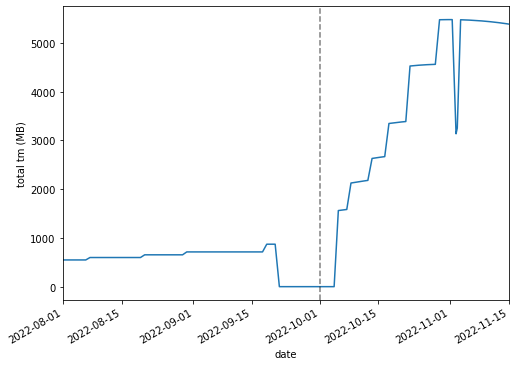

In [51]:
plt.figure(figsize=(8,6))
plt.plot(TM['date'], (TM['tm_rate']*TM['duration'])/8/1e6)#; plt.ylim(0,5000)
plt.xlim(datetime.date(2022,8,1),datetime.date(2022,11,15))
plt.gcf().autofmt_xdate()
plt.axvline(DT(2022,10,1),color='k',linestyle='--',alpha=.5)
# plt.plot(TMnew['date'], np.cumsum(TMnew['tm_rate']*TMnew['duration']));
# plt.ylabel('total tm_rate (bit/s)')
plt.ylabel('total tm (MB)')
plt.xlabel('date')


In [52]:
PHI = PHI_MEMORY(DT(2022,9,19,0,0,0))

max_flush = 700

# SYNOPTIC and FDT flat in LTP-8

None
number of datasets: 28
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 5767.8 MiB, 206.0 MiB per dataset
amount of crop-data at 32 bits: 2990.7 MiB, 106.8 MiB per dataset
cropping time: 0:20:46.504000
amount of pack-data at 16 bits: 1709.0 MiB, 61.0 MiB per dataset
packing time: 0:19:20.364800
compressing (+ flushing) time: 1:10:29.874432
amount of compressed data + metadata at 6 bits: 504.2 MiB, 18.0 MiB per dataset
amount of metadata:  24 MiB
amount of memory usage: 10467.5 MiB

None
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 206.0 MiB, 20.6 MiB per dataset
packing time: 0:01:23.806400
compressing (+ flushing) time: 0:10:04.051776
amount of compressed data + metadata at 6 bits: 72.0 MiB, 72.0 MiB per dataset
amount of metadata:  16 MiB
amount of memory usage: 4173.3 MiB



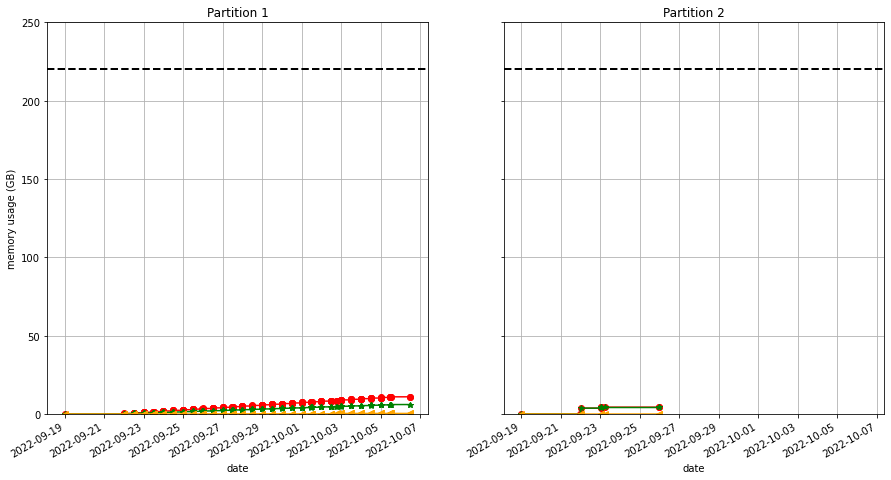

In [53]:
i = 1
crop = 1024

t0 = DT(2022,9,22,0,0,0)
FDTf0 = FDT_flat(t0,proc=DT(2022,9,23,1,0,0),flush=DT(2022,9,25,23,0,0),idx=2,verbose=False)


SYN = PHI_MODE('FDT')
t1 = DT(2022,10,6,0,0,0)
cadence = 12*60
N = int((t1 - t0).total_seconds() / (60*cadence))

ti = t0
deltat = (t1 - t0)/N
min1 = TD(minutes=1)

for n in range(N):
    kw = SYN.observation(ti,ti+min1,cadence=1,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
    kw = SYN.cropping(kw['end'],[crop,crop],ndata=1,level='raw'); PHI.saving(i,**kw)
    kw = SYN.packing(kw['end'] + TD(minutes=5),ndata=1,level='raw.crop'); PHI.saving(i,**kw)

    ti = ti + deltat

kw = SYN.compressing(DT(2022,9,25,23,15,0),ndata=6,nbits=6,level='raw.pack'); PHI.saving(i,**kw)
kw = SYN.compressing(DT(2022,10,2,18,0,0),ndata=14,nbits=6,level='raw.pack'); PHI.saving(i,**kw)
kw = SYN.compressing(DT(2022,10,6,12,0,0),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

# t0 = DT(2022,9,23,0,0,0)
# t1 = DT(2022,10,6,0,0,0)
# synoptic(SYN,t0,t1,12*60,(2048,2048,4,6),5,6,i,False)
plot_tot(PHI,ylim=(0,250),time_ord=True)
printp(SYN)
printp(FDTf0)

# <span style="color:red">Flat Fields</span> <br>
4 HRT and 4 FDT flats

In [54]:
i = 1

FDTf1 = FDT_flat(DT(2022,10,7,18,0,0),proc=DT(2022,10,8,1,0,0),flush='auto',idx=2,verbose=False)
FDTf2 = FDT_flat(DT(2022,10,7,20,0,0),proc=DT(2022,10,8,1,0,0),flush='auto',idx=2,verbose=False)
FDTf3 = PHI_MODE('FDT')

t0 = DT(2022,10,13,15,0,0)
t1 = t0+TD(minutes=55)
proc_time = TD(hours=5)

kw = FDTf3.observation(t0,t1,cadence=6,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

kw = FDTf3.observation(DT(2022,10,14,1,0,0),1,cadence=proc_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = FDTf3.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)

kw = FDTf3.compressing(DT(2022,10,14,20,0,0),ndata=5,nbits=6,level='raw.pack'); PHI.saving(i,**kw)
kw = FDTf3.compressing(DT(2022,10,15,20,0,0),ndata=5,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

printp(FDTf3)

# FDTf3 = FDT_flat(DT(2022,10,13,15,0,0),proc='auto',flush='auto',idx=2,verbose=False)
FDTf4 = FDT_flat(DT(2022,10,27,23,0,0),proc='auto',flush='auto',idx=2,verbose=False)

HRTf1 = HRT_flat(DT(2022,10,7,0,0,0),proc=DT(2022,10,7,16,0,0),flush='auto',idx=2,verbose=False)
HRTf2 = HRT_flat(DT(2022,10,7,8,0,0),proc=DT(2022,10,7,17,0,0),flush='auto',idx=2,verbose=False)
HRTf3 = HRT_flat(DT(2022,10,23,12,0,0),proc='auto',flush='auto',idx=2,verbose=False)
HRTf4 = HRT_flat(DT(2022,11,4,0,0,0),proc='auto',flush='auto',idx=2,verbose=False)


None
number of datasets: 10
cadence: 300.0 mins
duration: 5:00:00
amount of raw-data at 32 bits: 3967.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 2059.9 MiB, 206.0 MiB per dataset
packing time: 0:13:58.064000
compressing (+ flushing) time: 1:40:40.517760
amount of compressed data + metadata at 6 bits: 720.1 MiB, 72.0 MiB per dataset
amount of metadata:  88 MiB
amount of memory usage: 6027.2 MiB



# <span style="color:magenta">***RESET NAND 2 (flats only)***</span>

In [55]:
# copying processed flat == one dataset observation
i = 1
copy_time = TD(minutes=10)
kw = FDTf0.observation(DT(2022,10,9,2,0,0),1,cadence=copy_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = FDTf1.observation(kw['end'],1,cadence=copy_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = FDTf2.observation(kw['end'],1,cadence=copy_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = HRTf1.observation(kw['end'],1,cadence=copy_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = HRTf2.observation(kw['end'],1,cadence=copy_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

print('amount of compressed data + metadata in partition 1:',round(PHI.part2.compr*1e-3,2), 'GB')
PHI.format_partition(2,kw['end'] + TD(minutes=10))

# copying back processed flat == one dataset observation
i = 2
copy_time = TD(minutes=10)
kw = FDTf0.observation(DT(2022,10,9,14,0,0),1,cadence=copy_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = FDTf1.observation(kw['end'],1,cadence=copy_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = FDTf2.observation(kw['end'],1,cadence=copy_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = HRTf1.observation(kw['end'],1,cadence=copy_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = HRTf2.observation(kw['end'],1,cadence=copy_time.total_seconds()/60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)


amount of compressed data + metadata in partition 1: 0.6 GB


# <span style="color:blue">CC_OFFPOI_ALIGNMENT</span> <br>
06/10 (12:00 - 20:40)

alignment campaign, we could have one fdt at the beginning and one at the end and 5 hrt (dc, n, s, w, e limb)

FDT CC_OFFPOI_ALIGNMENT
number of datasets: 2
cadence: 480 mins
duration: 16:00:00
amount of raw-data at 32 bits: 793.5 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 412.0 MiB, 206.0 MiB per dataset
packing time: 0:02:47.612800
compressing (+ flushing) time: 0:20:08.103552
amount of compressed data + metadata at 6 bits: 144.0 MiB, 72.0 MiB per dataset
amount of metadata:  32 MiB
amount of memory usage: 1205.4 MiB

HRT CC_OFFPOI_ALIGNMENT
number of datasets: 5
cadence: 60 mins
duration: 5:00:00
amount of raw-data at 32 bits: 1983.6 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 1030.0 MiB, 206.0 MiB per dataset
packing time: 0:06:59.032000
compressing (+ flushing) time: 0:50:20.258880
amount of compressed data + metadata at 6 bits: 360.0 MiB, 72.0 MiB per dataset
amount of metadata:  80 MiB
amount of memory usage: 3013.6 MiB



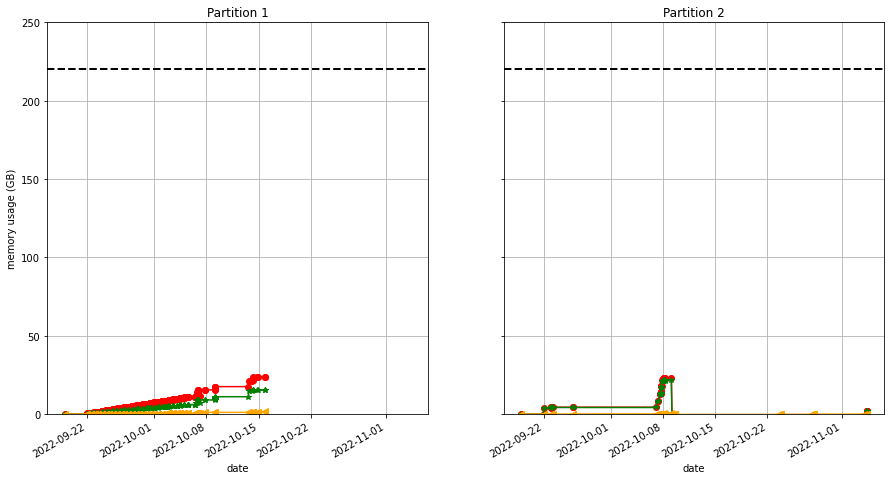

In [56]:
t0 = DT.fromisoformat('2022-10-06T12:00:00')
t1 = DT.fromisoformat('2022-10-06T20:40:00')

CCAL_FDT = PHI_MODE('FDT')
# synoptic(CCAL_FDT,t0,t1,6*60,(2048,2048,4,6),5,6,1,False)
kw = CCAL_FDT.observation(t0,2,cadence=8*60,shape=(2048,2048,4,6)); PHI.saving(1,**kw)


CCAL_HRT = PHI_MODE('HRT')
kw = CCAL_HRT.observation(t0+TD(hours=1),5,cadence=1*60,shape=(2048,2048,4,6)); PHI.saving(1,**kw)

kw = CCAL_FDT.packing(t1+TD(minutes=5),ndata=-1,level='raw'); PHI.saving(1,**kw)
kw = CCAL_HRT.packing(kw['end'],ndata=-1,level='raw'); PHI.saving(1,**kw)

kw = CCAL_FDT.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(1,**kw)
kw = CCAL_HRT.compressing(DT(2022,10,7,20,0,0),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(1,**kw)

printp(CCAL_FDT,label='FDT CC_OFFPOI_ALIGNMENT')

printp(CCAL_HRT,label='HRT CC_OFFPOI_ALIGNMENT')

plot_tot(PHI,ylim=(0,250),time_ord=True)

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">FDT Flat Calibration 1</span>

In [57]:
t0 = DT.fromisoformat('2022-10-07T18:00:00')
# t1 = DT.fromisoformat('2022-10-07T18:55:00')
# FDTf1 = PHI_MODE('FDT')

# kw = FDTf1.observation(t0,t1+TD(minutes=6),cadence=6,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
# kw = FDTf1.packing(kw['end'],ndata=1,level='raw',); PHI.saving(1,**kw)
# kw = FDTf1.compressing(kw['end'],ndata=1,nbits=6,level='raw.pack'); PHI.saving(1,**kw)

# ########################################################
# printp(FDTf1, label='FDT Flat Calibration')
# plot_tot(PHI,ylim=(0,250))

# FDTf1 = FDT_flat(t0,proc='auto',flush='auto',idx=1,verbose=True)

# <span style="color:blue">CORONAL DYNAMICSs</span> <br>

Processing and flushing during observation

CORONAL DYNAMICS, no crop, proc
number of datasets: 17
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 6744.4 MiB, 396.7 MiB per dataset
processing time: 9:55:00
amount of processed data (and intermediate data) at 16 bits: 7652.3 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 0:36:40.295040
amount of compressed data + metadata at 6 bits: 262.3 MiB, 15.4 MiB per dataset
amount of metadata:  16 MiB
amount of memory usage: 14396.7 MiB



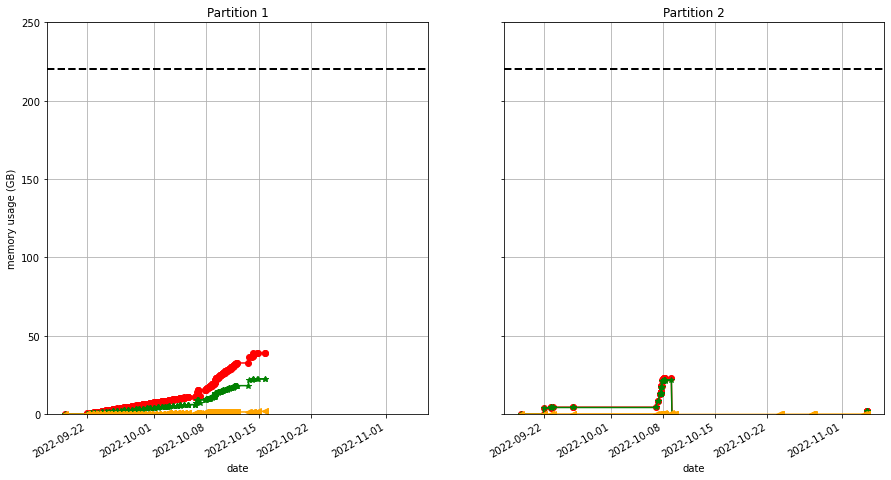

In [58]:
t0 = DT.fromisoformat('2022-10-08T00:00:00')
t1 = DT.fromisoformat('2022-10-12T06:00:00')

M1 = PHI_MODE('FDT')
synoptic(M1,t0,t1,6*60,(2048,2048,4,6),5,6,1,False)
# kw = M1.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
# kw = M1.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
# kw = M1.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

printp(M1,label='CORONAL DYNAMICS, no crop, proc')
plot_tot(PHI,ylim=(0,250))

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">RS-burst 1 / CAMPFIRE SOOP</span> <br>

crop to 1024x1024

RS-burst 1, 60 datasets, no crop, proc
number of datasets: 36
cadence: 5 mins
duration: 3:00:00
amount of raw-data at 32 bits: 7415.8 MiB, 206.0 MiB per dataset
amount of crop-data at 32 bits: 3845.2 MiB, 106.8 MiB per dataset
cropping time: 0:26:42.648000
amount of pack-data at 16 bits: 2197.3 MiB, 61.0 MiB per dataset
packing time: 0:24:51.897600
compressing (+ flushing) time: 1:30:38.409984
amount of compressed data + metadata at 6 bits: 648.3 MiB, 18.0 MiB per dataset
amount of metadata:  864 MiB
amount of memory usage: 13458.3 MiB



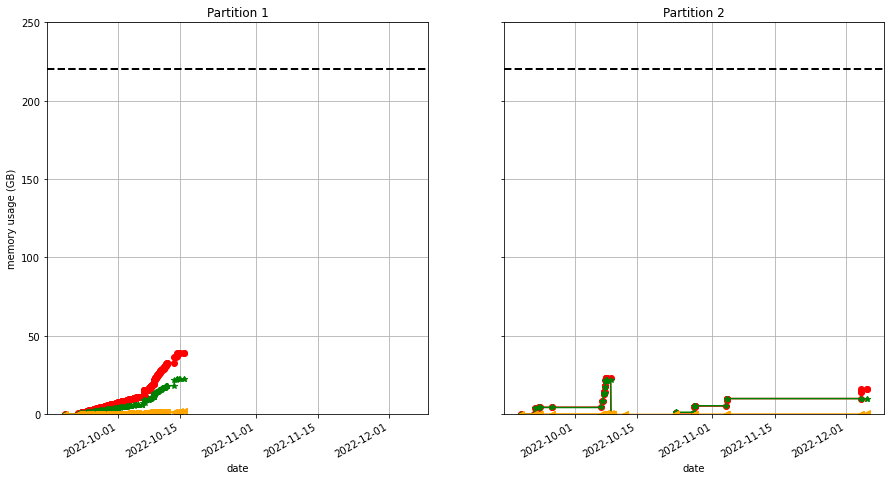

In [59]:

t0 = DT.fromisoformat('2022-10-12T06:00:00')
t1 = DT.fromisoformat('2022-10-12T09:00:00')
i = 2
crop = 1024

L1 = PHI_MODE('HRT')
kw = L1.observation(t0,t1,cadence=5,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
# kw = L1.observation(kw['end'],kw['end']+TD(hours=2,minutes=50),cadence=5,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
# kw = L1.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = L1.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(i,**kw)

# kw = L1.processing(DT(2022,10,12,9,0,0),ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = L1.cropping(DT(2022,12,4,9,0,0),crop=[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = L1.packing(kw['end']+TD(minutes=5),ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
kw = L1.compressing(DT(2022,12,5,18,0,0),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

# TC += (L1.proc.end - L1.proc.start).total_seconds()/60/60
# TF += (L1.compr.end - L1.compr.start).total_seconds()/60/60

printp(L1,label='RS-burst 1, 60 datasets, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)


# <span style="color:blue">DENSITY FLUCTUACTIONS</span> <br>
12/10 - 13/10 (until 12:00)

Processing and flushing during observation

DENSITY FLUCTUACTIONS, no crop, proc
number of datasets: 4
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 1586.9 MiB, 396.7 MiB per dataset
processing time: 2:20:00
amount of processed data (and intermediate data) at 16 bits: 1800.5 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 0:08:37.716480
amount of compressed data + metadata at 6 bits: 61.7 MiB, 15.4 MiB per dataset
amount of metadata:  16 MiB
amount of memory usage: 3387.5 MiB



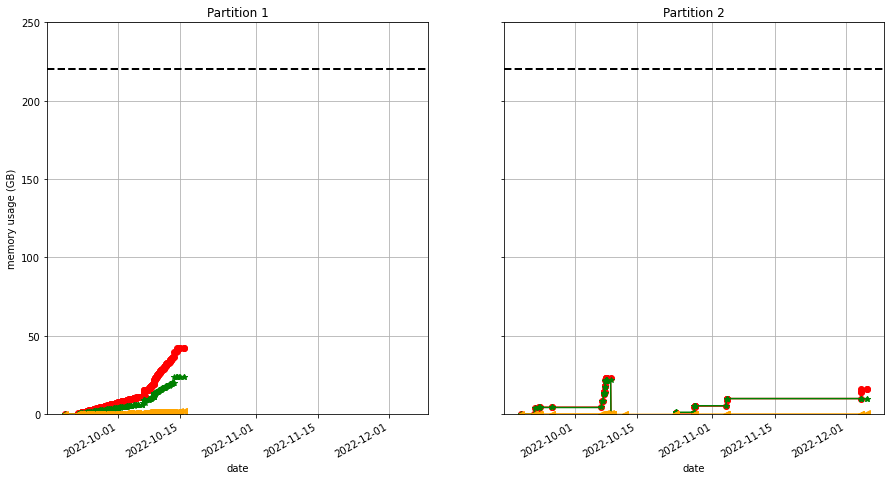

In [60]:
# t0 = DT.fromisoformat('2022-10-12T09:00:00')
t0 = DT.fromisoformat('2022-10-12T12:00:00')
t1 = DT.fromisoformat('2022-10-13T12:00:00')

M2 = PHI_MODE('FDT')
synoptic(M2,t0,t1,6*60,(2048,2048,4,6),5,6,1,False)
# kw = M2.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
# kw = M2.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
# kw = M2.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

printp(M2,label='DENSITY FLUCTUACTIONS, no crop, proc')
plot_tot(PHI,ylim=(0,250))

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">RS-burst 2</span> <br>
13/10 (12:00 - 15:00)

30m@1m HRT + 2h30m@5m

No time for processing and flushing

cropping 1536x1536 and packing

Days needed: 13
Exceeding the number of datasets, ndata set to 0
RS-burst 2, 1h@100s + 2h@5m, pack
number of datasets: 60
cadence: 5 mins
duration: 2:00:00
amount of raw-data at 32 bits: 23803.7 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 12359.6 MiB, 206.0 MiB per dataset
packing time: 1:23:48.384000
compressing (+ flushing) time: 10:04:03.106560
amount of compressed data + metadata at 6 bits: 4320.5 MiB, 72.0 MiB per dataset
amount of metadata:  672 MiB
amount of memory usage: 36163.3 MiB



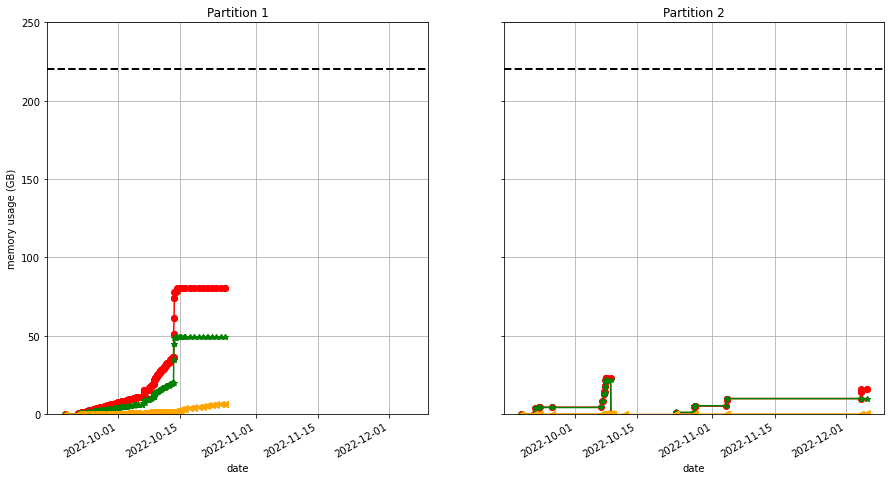

In [61]:
t0 = DT.fromisoformat('2022-10-13T12:00:00')
t1 = DT.fromisoformat('2022-10-13T13:00:00')
i = 1
crop = 2048#128*14

L2 = PHI_MODE('HRT')
kw = L2.observation(t0,t1,cadence=100/60,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
kw = L2.observation(kw['end'],kw['end']+TD(hours=2),cadence=5,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
# kw = L2.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = L2.cropping(kw['end'],[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = L2.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
# kw = L2.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)
L2, kw = flush_many([500,500],72,L2,DT(2022,10,13,18,0,0),6,-1,'raw.pack',i)
# kw = L2.compressing(DT(2022,10,14,1,0,0),ndata=24,nbits=6,level='raw.pack'); PHI.saving(i,**kw)
# kw = L2.compressing(DT(2022,10,15,1,0,0),ndata=24,nbits=6,level='raw.pack'); PHI.saving(i,**kw)
# kw = L2.compressing(DT(2022,10,16,6,0,0),ndata=12,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

# kw = L2.processing(DT(2022,10,13,15,0,0),ndata=24,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = L2.compressing(DT(2022,10,14,1,0,0),ndata=24,nbits=6,level='proc'); PHI.saving(i,**kw)
# kw = L2.processing(DT(2022,10,14,1,0,0),ndata=24,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = L2.compressing(DT(2022,10,15,1,0,0),ndata=24,nbits=6,level='proc'); PHI.saving(i,**kw)
# kw = L2.processing(DT(2022,10,16,0,0,0),ndata=12,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = L2.compressing(DT(2022,10,16,6,0,0),ndata=12,nbits=6,level='proc'); PHI.saving(i,**kw)

# TC += (L2.proc.end - L2.proc.start).total_seconds()/60/60
# TF += (L2.compr.end - L2.compr.start).total_seconds()/60/60

printp(L2,label='RS-burst 2, 1h@100s + 2h@5m, pack')
plot_tot(PHI,ylim=(0,250),time_ord=True)

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">CONNECTION MOSAIC</span> <br>
13/10 - 15/10

CONNECTION MOSAIC, crop, proc
number of datasets: 6
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 1785.3 MiB, 297.5 MiB per dataset
amount of crop-data at 32 bits: 1373.3 MiB, 228.9 MiB per dataset
cropping time: 0:05:34.500000
amount of pack-data at 16 bits: 732.4 MiB, 122.1 MiB per dataset
packing time: 0:05:54.561600
compressing (+ flushing) time: 0:33:58.863744
amount of compressed data + metadata at 6 bits: 243.1 MiB, 40.5 MiB per dataset
amount of metadata:  24 MiB
amount of memory usage: 3891.0 MiB



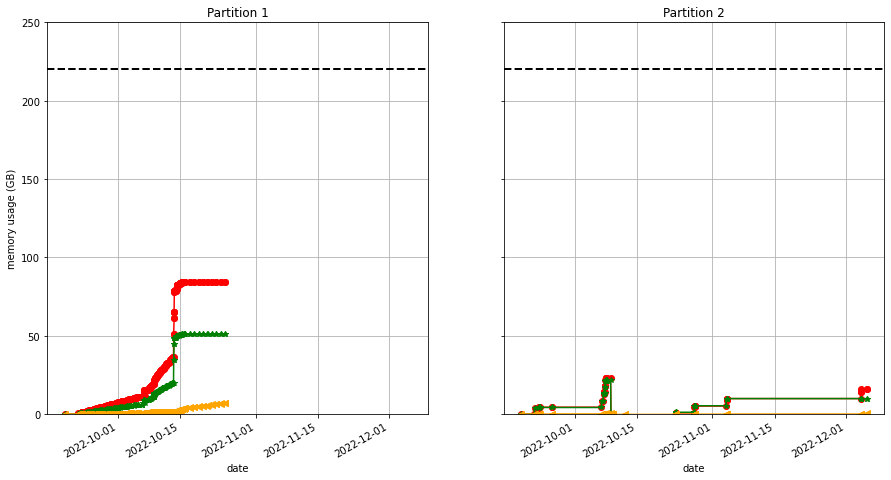

In [62]:
t0 = DT.fromisoformat('2022-10-13T15:00:00')
t1 = t0 + TD(hours=5*10) # DT.fromisoformat('2022-10-15T18:00:00')
crop = 1536

CM = PHI_MODE('HRT')
synoptic_raw(CM,t0,t1,8*60,(2048,crop,4,6),6,1,False)
# kw = CM.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
# kw = CM.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
# kw = CM.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

printp(CM,label='CONNECTION MOSAIC, crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">CC_OFFPOI_OOF</span> <br>
15/10 (from 18:00)

CC_OFFPOI_OOF, 4 datasets, crop, proc
number of datasets: 2
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 595.1 MiB, 297.5 MiB per dataset
amount of crop-data at 32 bits: 457.8 MiB, 228.9 MiB per dataset
cropping time: 0:01:51.500000
amount of pack-data at 16 bits: 244.1 MiB, 122.1 MiB per dataset
packing time: 0:01:58.187200
compressing (+ flushing) time: 0:11:19.621248
amount of compressed data + metadata at 6 bits: 81.0 MiB, 40.5 MiB per dataset
amount of metadata:  24 MiB
amount of memory usage: 1297.0 MiB



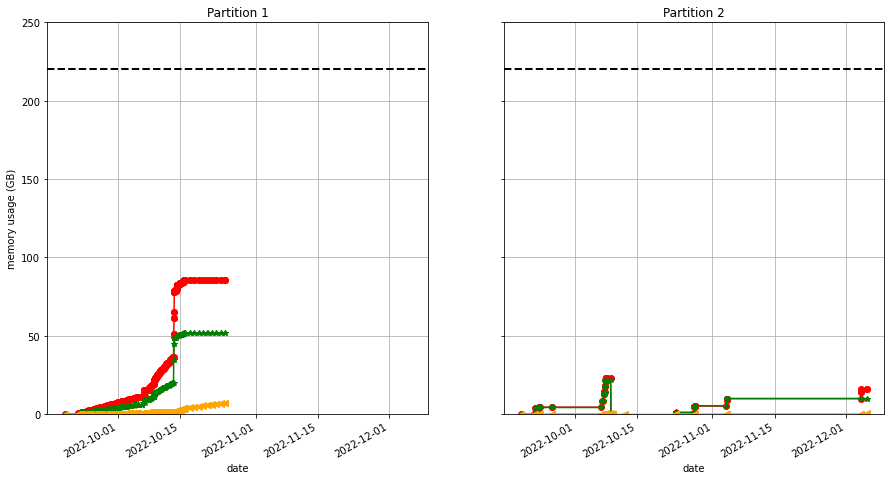

In [63]:
t0 = DT.fromisoformat('2022-10-15T18:00:00')
t1 = DT.fromisoformat('2022-10-15T22:00:00')
crop = 1536

CC = PHI_MODE('HRT')
synoptic_raw(CC,t0,t1,2*60,(2048,crop,4,6),6,1,False)
# kw = CC.observation(t0,t1,cadence=120,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
# kw = CC.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
# kw = CC.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

printp(CC,label='CC_OFFPOI_OOF, 4 datasets, crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">POLAR-OBSERVATIONS</span> <br>
16/10 (00:00 - 12:00)

80 datasets (12 hours reserved)

cropping to 1024x1024


POLAR, 80 datasets, no crop, proc
number of datasets: 24
cadence: 2 mins
duration: 0:48:00
amount of raw-data at 32 bits: 4943.8 MiB, 206.0 MiB per dataset
amount of crop-data at 32 bits: 2563.5 MiB, 106.8 MiB per dataset
cropping time: 0:17:48.432000
amount of pack-data at 16 bits: 1464.8 MiB, 61.0 MiB per dataset
packing time: 0:16:34.598400
compressing (+ flushing) time: 1:00:25.606656
amount of compressed data + metadata at 6 bits: 432.2 MiB, 18.0 MiB per dataset
amount of metadata:  576 MiB
amount of memory usage: 8972.2 MiB



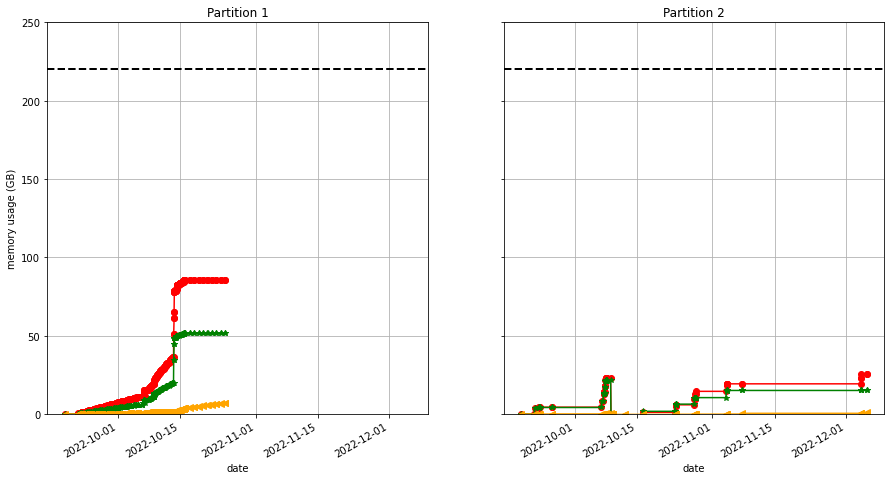

In [64]:
t0 = DT.fromisoformat('2022-10-16T09:00:00')
# t1 = DT.fromisoformat('2022-10-13T13:00:00')
i = 2
crop = 1024

PO = PHI_MODE('HRT')
kw = PO.observation(t0,24,cadence=2,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
# kw = PO.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = PO.packing(kw['end'],ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = PO.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = PO.cropping(DT(2022,10,28,5,0,0),[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = PO.packing(DT(2022,10,28,7,0,0),ndata=-1,level='raw.crop'); PHI.saving(i,**kw)
kw = PO.compressing(DT(2022,11,7,18,0,0),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

# TC += (PO.proc.end - PO.proc.start).total_seconds()/60/60
# TF += (PO.compr.end - PO.compr.start).total_seconds()/60/60

printp(PO,label='POLAR, 80 datasets, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)


# <span style="color:magenta">***NO!! RESET NAND 1 (?)***</span>

In [65]:
# print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e6/2**30,2), 'GiB')
# print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e6/2**30,2), 'GiB')
# tm0 = DT(2022,3,2,0,0,0)
# tm1 = DT(2022,3,15,0,0,0)
# _ = tm_avail(tm0,tm1,df_tm,frac=.2)
# print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')
# print('TM time:',round((PHI.part1.compr + PHI.part2.compr)/2151.3,2), 'days')
# PHI.format_partition(1,end + TD(hours=1))
# phi.format_partition(1,end + TD(hours=1))
# phi.format_partition(2,PHI.part2.history['end'][-1] + TD(hours=.5))


# print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e-3,2), 'GB')
# PHI.format_partition(1,PHI.part1.history['end'][-1] + TD(hours=.5))


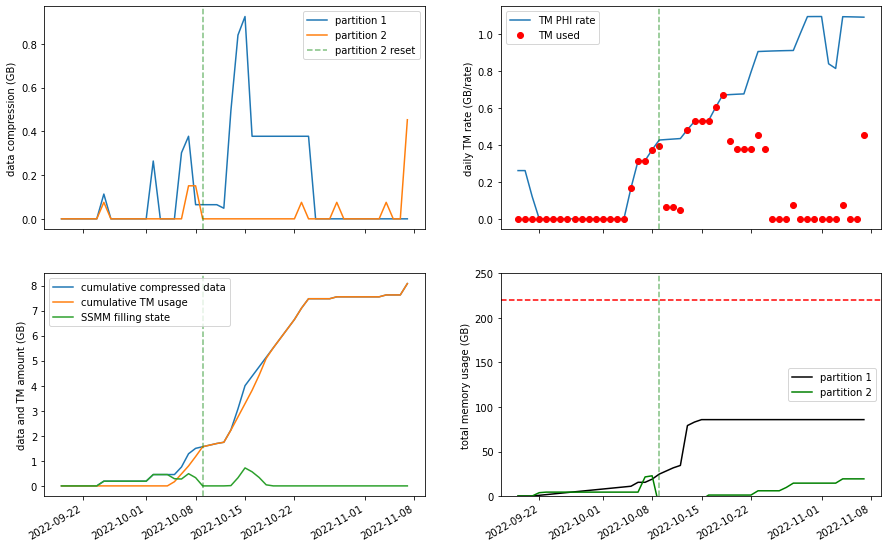

In [66]:
final_plot(PHI,TM)

# <span style="color:blue">AR Long Term</span> <br>
16/10 - 28/10 (from 12:00)

272 datasets

***3 BURSTS FOR ANDREJ SOOP? NO***

all raw, crop 1536x1536

Days needed: 6
Exceeding the number of datasets, ndata set to 9
Days needed: 22
Exceeding the number of datasets, ndata set to 0
AR Long Term, crop, raw
number of datasets: 89
cadence: 60 mins
duration: 3 days, 17:00:00
amount of raw-data at 32 bits: 26481.6 MiB, 297.5 MiB per dataset
amount of crop-data at 32 bits: 20370.5 MiB, 228.9 MiB per dataset
cropping time: 1:22:41.750000
amount of pack-data at 16 bits: 10864.3 MiB, 122.1 MiB per dataset
packing time: 1:27:39.330400
compressing (+ flushing) time: 8:24:03.145536
amount of compressed data + metadata at 6 bits: 3605.3 MiB, 40.5 MiB per dataset
amount of metadata:  2136 MiB
amount of memory usage: 57716.4 MiB

AR Long Term, no crop, raw
number of datasets: 168
cadence: 60 mins
duration: 7 days, 0:00:00
amount of raw-data at 32 bits: 66650.4 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 34606.9 MiB, 206.0 MiB per dataset
packing time: 3:54:39.475200
compressing (+ flushing) time: 1 day, 4:11:20.698368
amount of compress

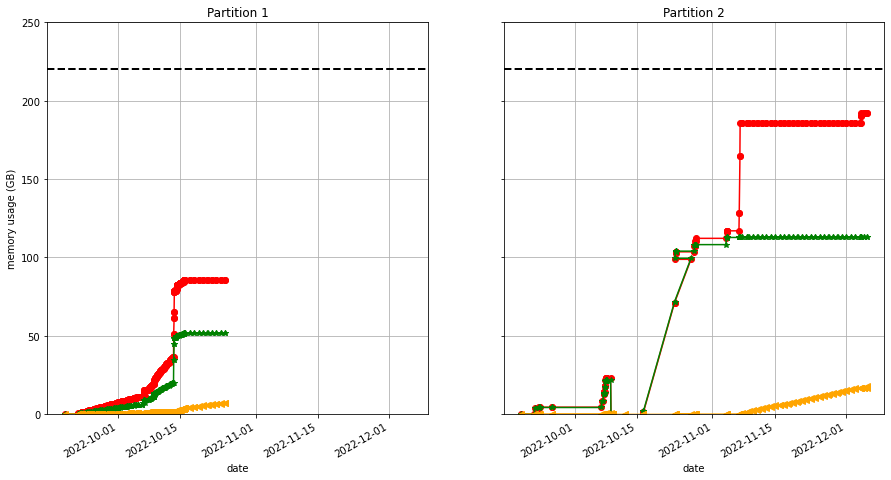

In [67]:
t0 = DT.fromisoformat('2022-10-16T12:00:00')
t1 = DT.fromisoformat('2022-10-27T20:00:00')
i = 2
Nraw = 24*7 # no observation during WOL # 176
crop = 1536

# ALp = PHI_MODE('HRT')
# kw = ALp.observation(t0,272-Nraw,cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw); t0 = kw['end']

ALr = PHI_MODE('HRT')
kw = ALr.observation(t0,Nraw,cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
ALc = PHI_MODE('HRT')
kw = ALc.observation(kw['end'],257-Nraw,cadence=60,shape=(2048,crop,4,6)); PHI.saving(i,**kw)


# kw = ALp.processing(DT(2022,10,17,19,0,0),ndata=4,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=4,nbits=6,level='proc'); PHI.saving(i,**kw)
# kw = ALp.processing(DT(2022,10,19,19,0,0),ndata=4,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=4,nbits=6,level='proc'); PHI.saving(i,**kw)
# kw = ALp.processing(DT(2022,10,21,19,0,0),ndata=4,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=4,nbits=6,level='proc'); PHI.saving(i,**kw)
# kw = ALp.processing(DT(2022,10,23,19,0,0),ndata=4,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=4,nbits=6,level='proc'); PHI.saving(i,**kw)
# kw = ALp.processing(DT(2022,10,25,19,0,0),ndata=4,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=4,nbits=6,level='proc'); PHI.saving(i,**kw)
# kw = ALp.processing(DT(2022,10,27,19,0,0),ndata=4,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=4,nbits=6,level='proc'); PHI.saving(i,**kw)

# kw = ALp.processing(DT(2022,10,28,19,0,0),ndata=6,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=6,nbits=6,level='proc'); PHI.saving(i,**kw)

# kw = ALp.processing(DT(2022,10,29,1,0,0),ndata=18,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=18,nbits=6,level='proc'); PHI.saving(i,**kw)

# kw = ALp.processing(DT(2022,10,30,1,0,0),ndata=18,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=18,nbits=6,level='proc'); PHI.saving(i,**kw)

# kw = ALp.processing(DT(2022,10,31,1,0,0),ndata=18,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=18,nbits=6,level='proc'); PHI.saving(i,**kw)

# kw = ALp.processing(DT(2022,11,1,1,0,0),ndata=6,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=6,nbits=6,level='proc'); PHI.saving(i,**kw)

# kw = ALp.processing(DT(2022,11,1,2,0,0),ndata=6,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
# kw = ALp.compressing(kw['end'],ndata=6,nbits=6,level='proc'); PHI.saving(i,**kw)


# TC += (ALp.proc.end - ALp.proc.start).total_seconds()/60/60
# TF += (ALp.compr.end - ALp.compr.start).total_seconds()/60/60

# printp(ALp,label='AR Long Term, no crop, proc')

kw = ALc.cropping(DT(2022,11,7,5,0,0),[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ALc.packing(DT(2022,11,7,0,0),ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
kw = ALr.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
ALc, kw = flush_many([max_flush,max_flush],40.5,ALc,DT(2022,11,8,18,0,0),6,-1,'raw.pack',i)
tF = ALc.compr.pack.end + TD(days=1)
ALr, kw = flush_many([max_flush,max_flush],72,ALr,tF,6,-1,'raw.pack',i)
tF = ALr.compr.pack.end + TD(days=1)
# kw = ALr.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

printp(ALc,label='AR Long Term, crop, raw')
printp(ALr,label='AR Long Term, no crop, raw')

plot_tot(PHI,ylim=(0,250),time_ord=True)

In [68]:
ALr.compr.pack.end

datetime.datetime(2022, 12, 5, 3, 0, 0, 295616)

# <span style="color:blue">ATMOSPHERIC-DYNIMICS-STRUCTURE 1</span> <br>
27/10 (20:00-24:00)


Days needed: 6
Exceeding the number of datasets, ndata set to 8
AR-HRES-RSW1, 2d@10m, no crop, proc
number of datasets: 108
cadence: 1.6666666666666667 mins
duration: 3:00:00
amount of raw-data at 32 bits: 32135.0 MiB, 297.5 MiB per dataset
amount of crop-data at 32 bits: 24719.2 MiB, 228.9 MiB per dataset
cropping time: 1:40:21
amount of pack-data at 16 bits: 13183.6 MiB, 122.1 MiB per dataset
packing time: 1:46:22.108800
compressing (+ flushing) time: 10:11:39.547392
amount of compressed data + metadata at 6 bits: 4374.9 MiB, 40.5 MiB per dataset
amount of metadata:  2592 MiB
amount of memory usage: 70037.8 MiB



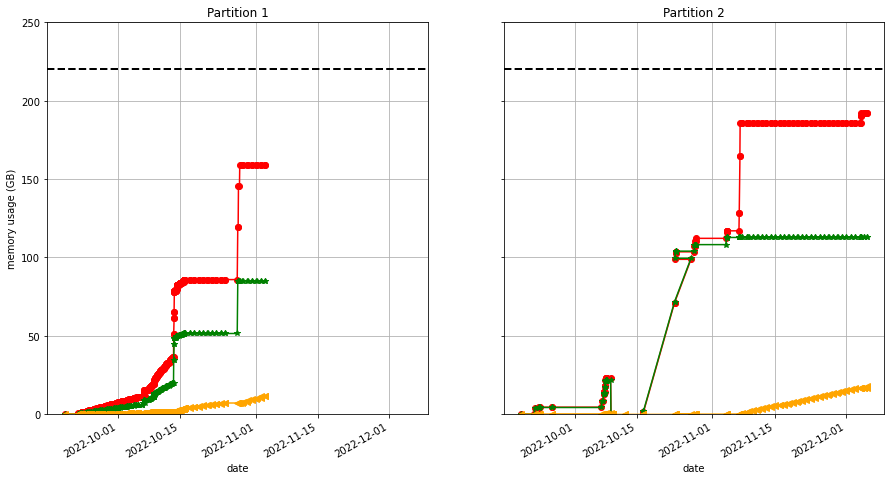

In [69]:
t0 = DT.fromisoformat('2022-10-27T20:00:00')
t1 = DT.fromisoformat('2022-10-27T23:00:00')
i = 1
crop = 1536

ADS1 = PHI_MODE('HRT')
kw = ADS1.observation(t0,t1,cadence=100/60,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
# kw = ADS1.cropping(t0,[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = ADS1.packing(kw['end'],ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
# kw = ADS1.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = ADS1.cropping(DT(2022,10,28,1,0,0),[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ADS1.packing(DT(2022,10,28,8,0,0),ndata=-1,level='raw.crop',); PHI.saving(i,**kw)


ADS1, kw = flush_many([880,880],40.5,ADS1,DT(2022,10,29,0,0,0),6,-1,'raw.pack',i)
printp(ADS1,label='AR-HRES-RSW1, 2d@10m, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)


In [70]:
ADS1.compr.pack.end

datetime.datetime(2022, 11, 3, 3, 45, 18, 484992)

# <span style="color:blue">CH-BOUNDARY-EXPANSION</span> <br>
28/10

Processing and flushing during observation

20h free for flush all data in partition 1

CH-BOUNDARY-EXPANSION, crop, proc
number of datasets: 4
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 1586.9 MiB, 396.7 MiB per dataset
processing time: 2:20:00
amount of processed data (and intermediate data) at 16 bits: 1739.5 MiB, 38.1 MiB per dataset
compressing (+ flushing) time: 0:05:10.629888
amount of compressed data + metadata at 6 bits: 37.0 MiB, 9.3 MiB per dataset
amount of metadata:  16 MiB
amount of memory usage: 3326.4 MiB



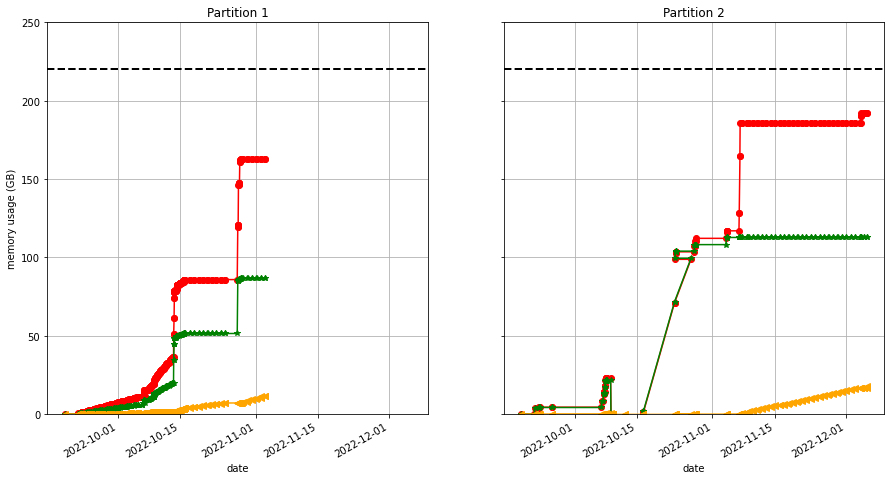

In [71]:
t0 = DT.fromisoformat('2022-10-28T00:00:00')
t1 = DT.fromisoformat('2022-10-29T00:00:00')
i = 1
crop = 2048

M3 = PHI_MODE('FDT')
synoptic(M3,t0,t1,6*60,(2048,crop,4,6),3,6,i,False)
# kw = M2.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = M2.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw'); PHI.saving(i,**kw)
# kw = M2.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(i,**kw)

printp(M3,label='CH-BOUNDARY-EXPANSION, crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">ERUPTION WATCH 1-7</span> <br>
FROM 29/10, 8 DAYAS WITH BREAKS

ERUPTION WATCH, 7 SOOPS, no crop, proc
number of datasets: 21
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 8331.3 MiB, 396.7 MiB per dataset
processing time: 12:15:00
amount of processed data (and intermediate data) at 16 bits: 9132.4 MiB, 38.1 MiB per dataset
compressing (+ flushing) time: 0:27:10.806912
amount of compressed data + metadata at 6 bits: 194.4 MiB, 9.3 MiB per dataset
amount of metadata:  16 MiB
amount of memory usage: 17463.7 MiB



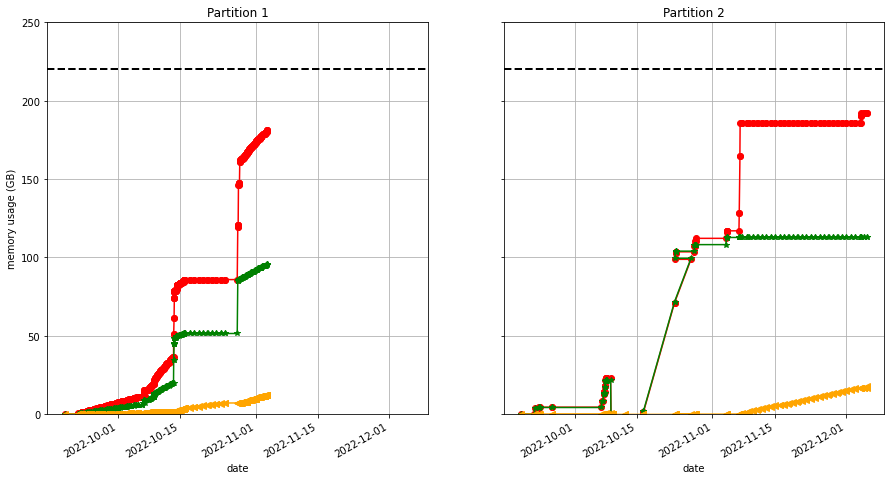

In [72]:
t0 = DT.fromisoformat('2022-10-29T00:00:00')
t1 = DT.fromisoformat('2022-10-30T00:00:00')
i = 1
crop = 2048

M4 = PHI_MODE('FDT')
synoptic(M4,t0,t1,6*60,(2048,crop,4,6),3,6,i,False)

t0 = DT.fromisoformat('2022-10-30T00:00:00')
t1 = DT.fromisoformat('2022-10-31T00:00:00')
synoptic(M4,t0,t1,6*60,(2048,crop,4,6),3,6,i,False)

t0 = DT.fromisoformat('2022-10-31T00:00:00')
t1 = DT.fromisoformat('2022-11-01T00:00:00')
synoptic(M4,t0,t1,6*60,(2048,crop,4,6),3,6,i,False)

t0 = DT.fromisoformat('2022-11-01T00:00:00')
t1 = DT.fromisoformat('2022-11-01T18:00:00')
synoptic(M4,t0,t1,6*60,(2048,crop,4,6),3,6,i,False)

t0 = DT.fromisoformat('2022-11-02T00:00:00')
t1 = DT.fromisoformat('2022-11-02T18:00:00')
synoptic(M4,t0,t1,6*60,(2048,crop,4,6),3,6,i,False)

t0 = DT.fromisoformat('2022-11-03T00:00:00')
t1 = DT.fromisoformat('2022-11-03T19:00:00')
synoptic(M4,t0,t1,6*60,(2048,crop,4,6),3,6,i,False)

# t0 = DT.fromisoformat('2022-11-04T00:00:00')
# t1 = DT.fromisoformat('2022-11-04T18:00:00')
# synoptic(M4,t0,t1,6*60,(2048,crop,4,6),3,6,i,False)

# kw = M3.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = M3.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw'); PHI.saving(i,**kw)
# kw = M3.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(i,**kw)

printp(M4,label='ERUPTION WATCH, 7 SOOPS, no crop, proc')
plot_tot(PHI,ylim=(0,250))

# PHI.format_partition(1,kw['end'] + TD(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">AR_HEATING</span> <br>
29-31/10 (22:00-24:00)

3 bursts

crop 1536x1536

AR_HEATING, 6h@1m, no crop, raw
number of datasets: 6
cadence: 60 mins
duration: 2:00:00
amount of raw-data at 32 bits: 1785.3 MiB, 297.5 MiB per dataset
amount of crop-data at 32 bits: 1373.3 MiB, 228.9 MiB per dataset
cropping time: 0:05:34.500000
amount of pack-data at 16 bits: 732.4 MiB, 122.1 MiB per dataset
packing time: 0:05:54.561600
compressing (+ flushing) time: 0:33:58.863744
amount of compressed data + metadata at 6 bits: 243.1 MiB, 40.5 MiB per dataset
amount of metadata:  48 MiB
amount of memory usage: 3891.0 MiB



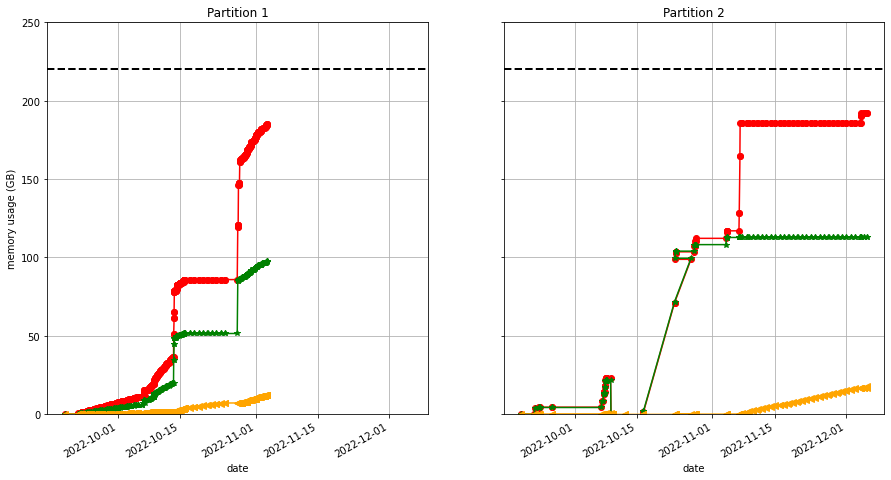

In [73]:
t0 = DT.fromisoformat('2022-10-29T22:00:00')
t1 = DT.fromisoformat('2022-10-30T00:00:00')
i = 1
crop = 1536

ARH = PHI_MODE('FDT')
kw = ARH.observation(t0,t1,cadence=60,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
kw = ARH.cropping(kw['end'],[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ARH.packing(kw['end'],ndata=2,level='raw.crop',); PHI.saving(i,**kw)
kw = ARH.compressing(kw['end'],ndata=2,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = ARH.observation(t0+TD(days=1),t1+TD(days=1),cadence=60,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
kw = ARH.cropping(kw['end'],[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ARH.packing(kw['end'],ndata=2,level='raw.crop',); PHI.saving(i,**kw)
kw = ARH.compressing(kw['end'],ndata=2,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = ARH.observation(t0+TD(days=2),t1+TD(days=2),cadence=60,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
kw = ARH.cropping(kw['end'],[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ARH.packing(kw['end'],ndata=2,level='raw.crop',); PHI.saving(i,**kw)
kw = ARH.compressing(kw['end'],ndata=2,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

# kw = ARH.cropping(t0,[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = ARH.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
# kw = ARH.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

printp(ARH,label='AR_HEATING, 6h@1m, no crop, raw')
plot_tot(PHI,ylim=(0,250),time_ord=True)


# <span style="color:blue">AR_SUSANNA 1</span> <br>
1-3/11 (12:00-24:00)
3 runs

crop to 1408x1408


AR_SUSANNA 1, no crop, raw
number of datasets: 30
cadence: 60 mins
duration: 10:00:00
amount of raw-data at 32 bits: 8239.7 MiB, 274.7 MiB per dataset
amount of crop-data at 32 bits: 5722.0 MiB, 190.7 MiB per dataset
cropping time: 0:26:28.260000
amount of pack-data at 16 bits: 2975.5 MiB, 99.2 MiB per dataset
packing time: 0:27:00.559500
compressing (+ flushing) time: 2:22:46.404480
amount of compressed data + metadata at 6 bits: 1021.2 MiB, 34.0 MiB per dataset
amount of metadata:  240 MiB
amount of memory usage: 16937.3 MiB



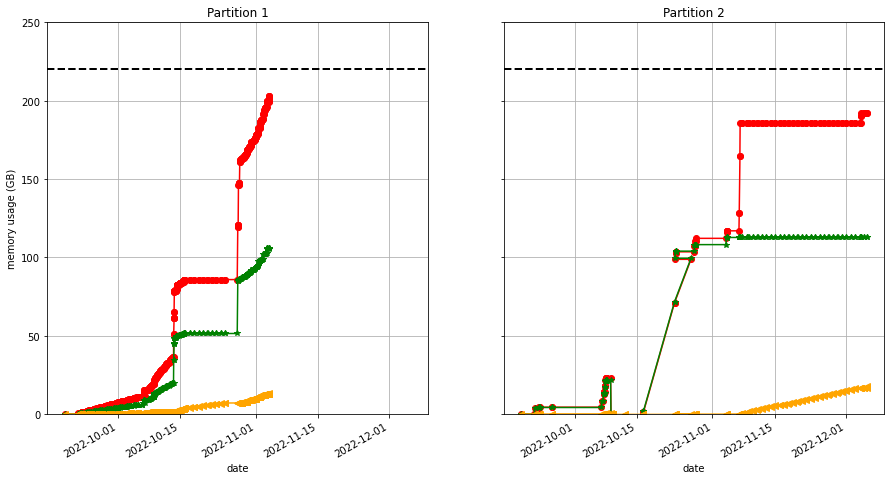

In [74]:
t0 = DT.fromisoformat('2022-11-01T12:30:00')
t1 = DT.fromisoformat('2022-11-01T22:30:00')
i = 1
crop = 1408

ARS1 = PHI_MODE('HRT')
kw = ARS1.observation(t0,t1,cadence=60,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
# kw = ARS1.observation(t0+TD(days=1),t1+TD(days=1),cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARS1.observation(t0+TD(days=2),t1+TD(days=2),cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = ARS1.cropping(kw['end'],[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ARS1.packing(kw['end'],ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
kw = ARS1.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

t0 = DT.fromisoformat('2022-11-02T12:30:00')
t1 = DT.fromisoformat('2022-11-02T22:30:00')

kw = ARS1.observation(t0,t1,cadence=60,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
# kw = ARS1.observation(t0+TD(days=1),t1+TD(days=1),cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARS1.observation(t0+TD(days=2),t1+TD(days=2),cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = ARS1.cropping(kw['end'],[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ARS1.packing(kw['end'],ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
kw = ARS1.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

t0 = DT.fromisoformat('2022-11-03T12:30:00')
t1 = DT.fromisoformat('2022-11-03T22:30:00')

kw = ARS1.observation(t0,t1,cadence=60,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
# kw = ARS1.observation(t0+TD(days=1),t1+TD(days=1),cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = ARS1.observation(t0+TD(days=2),t1+TD(days=2),cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = ARS1.cropping(kw['end'],[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ARS1.packing(kw['end'],ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
kw = ARS1.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

printp(ARS1,label='AR_SUSANNA 1, no crop, raw')
plot_tot(PHI,ylim=(0,250),time_ord=True)


In [75]:
ADS1.compr.pack.end

datetime.datetime(2022, 11, 3, 3, 45, 18, 484992)

# <span style="color:magenta">***RESET NAND 1***</span>

In [76]:
# print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')
# PHI.format_partition(2,DT(2022,11,4,6,0,0))
print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e-3,2), 'GB')
PHI.format_partition(1,DT(2022,11,4,6,0,0))

amount of compressed data + metadata in partition 1: 13.18 GB


In [77]:
PHI.part1.history['start'][np.argmax(PHI.part1.history['compr'])]

datetime.datetime(2022, 10, 29, 0, 0)

# <span style="color:blue">ATMOSPHERIC-DYNIMICS-STRUCTURE 2</span> <br>
4/11 (12:00-24:00)

cropping 1280x1280

flushing from 17/11 instead of 20/11

In [79]:
max_flush

700

Days needed: 19
Exceeding the number of datasets, ndata set to 18
ATMOSPHERIC-DYNIMICS-STRUCTURE 2, no crop, raw
number of datasets: 360
cadence: 1 mins
duration: 6:00:00
amount of raw-data at 32 bits: 98877.0 MiB, 274.7 MiB per dataset
amount of crop-data at 32 bits: 68664.6 MiB, 190.7 MiB per dataset
cropping time: 5:17:39.120000
amount of pack-data at 16 bits: 35705.6 MiB, 99.2 MiB per dataset
packing time: 5:24:06.714000
compressing (+ flushing) time: 1 day, 4:33:16.853760
amount of compressed data + metadata at 6 bits: 12254.3 MiB, 34.0 MiB per dataset
amount of metadata:  8640 MiB
amount of memory usage: 203247.1 MiB



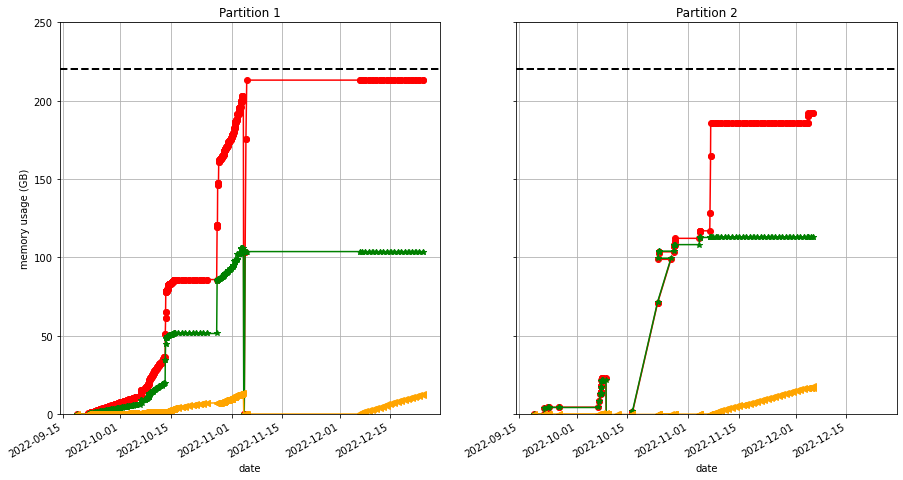

In [31]:
t0 = DT.fromisoformat('2022-11-04T12:00:00')
t1 = DT.fromisoformat('2022-11-05T00:00:00')
i = 1
crop = 1408 # 1536 # 1280 # 

ADS2 = PHI_MODE('HRT')
kw = ADS2.observation(t0,60*6,cadence=1,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
kw = ADS2.cropping(kw['end'],[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ADS2.packing(kw['end'],ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
# kw = ADS2.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

# kw = ADS2.packing(DT(2022,11,8,3,0,0),ndata=-1,level='raw',); PHI.saving(i,**kw)
ADS2, kw = flush_many([max_flush,max_flush],34,ADS2,DT(tF.year,tF.month,tF.day,17,0,0),ndata=-1,nbits=6,level='raw.pack',partition=i)
tF = ADS2.compr.pack.end + TD(days=1)

printp(ADS2,label='ATMOSPHERIC-DYNIMICS-STRUCTURE 2, no crop, raw')
plot_tot(PHI,ylim=(0,250),time_ord=True)


In [32]:
ADS2.compr.pack.end

datetime.datetime(2022, 12, 24, 4, 25, 39, 842688)

# <span style="color:blue">ERUPTION WATCH 8</span> <br>
5-6/11

ERUPTION WATCH, 8th SOOPS, no crop, raw
number of datasets: 5
cadence: 1 mins
duration: 0:01:00
amount of raw-data at 32 bits: 1487.7 MiB, 297.5 MiB per dataset
amount of crop-data at 32 bits: 1144.4 MiB, 228.9 MiB per dataset
cropping time: 0:04:38.750000
amount of pack-data at 16 bits: 610.4 MiB, 122.1 MiB per dataset
packing time: 0:04:55.468000
compressing (+ flushing) time: 0:28:19.053120
amount of compressed data + metadata at 6 bits: 202.5 MiB, 40.5 MiB per dataset
amount of metadata:  24 MiB
amount of memory usage: 3242.5 MiB



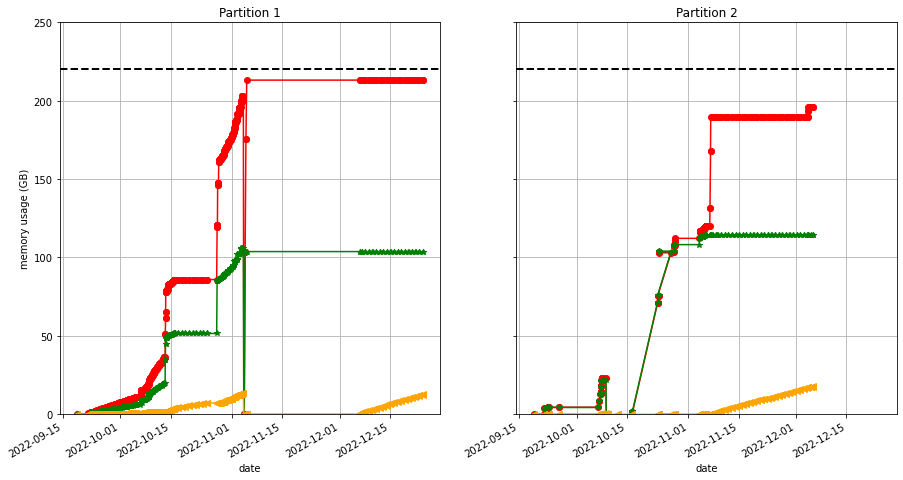

In [33]:
t0 = DT.fromisoformat('2022-11-05T00:00:00')
t1 = DT.fromisoformat('2022-11-06T06:00:00')
i = 2

M4r = PHI_MODE('FDT')
synoptic_raw(M4r,t0,t1,6*60,(2048,1536,4,6),6,i,False)

printp(M4r,label='ERUPTION WATCH, 8th SOOPS, no crop, raw')
plot_tot(PHI,ylim=(0,250),time_ord=True)


# <span style="color:blue">AR_SUSANNA 2</span> <br>
6/11 (04:30-11:30)

flushing on 29/11 instead of 6/12

crop to 1408x1408

AR_SUSANNA 2, no crop, raw
number of datasets: 7
cadence: 60 mins
duration: 7:00:00
amount of raw-data at 32 bits: 1922.6 MiB, 274.7 MiB per dataset
amount of crop-data at 32 bits: 1335.1 MiB, 190.7 MiB per dataset
cropping time: 0:06:10.594000
amount of pack-data at 16 bits: 694.3 MiB, 99.2 MiB per dataset
packing time: 0:06:18.130550
compressing (+ flushing) time: 0:33:18.827712
amount of compressed data + metadata at 6 bits: 238.3 MiB, 34.0 MiB per dataset
amount of metadata:  168 MiB
amount of memory usage: 3952.0 MiB



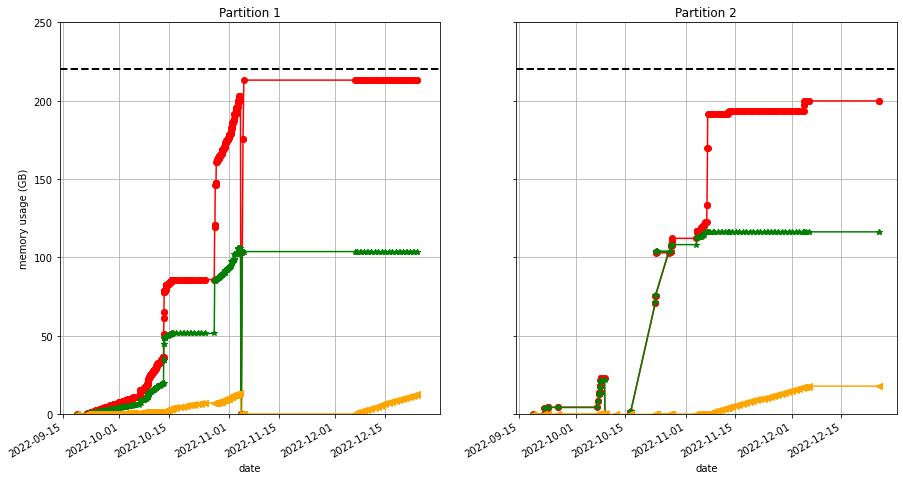

In [34]:
t0 = DT.fromisoformat('2022-11-06T04:30:00')
t1 = DT.fromisoformat('2022-11-06T11:30:00')
i = 2
crop = 1408

ARS2 = PHI_MODE('HRT')
kw = ARS2.observation(t0,t1,cadence=60,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
# kw = ARS2.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
# kw = ARS2.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = ARS2.cropping(DT(2022,11,13,3,0,0),[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = ARS2.packing(DT(2022,11,13,5,0,0),ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
kw = ARS2.compressing(DT(tF.year,tF.month,tF.day,17,0,0),ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)
tF = ARS2.compr.pack.end + TD(days=1)

printp(ARS2,label='AR_SUSANNA 2, no crop, raw')
plot_tot(PHI,ylim=(0,250),time_ord=True)


# <span style="color:blue">CRAZY MOSAIC</span> <br>
6/11
36 datasets

flushing from 24/12 instead of 7/12

Days needed: 5
Exceeding the number of datasets, ndata set to 4
Crazy Mosaic, 36 datasets, no crop, proc
number of datasets: 36
cadence: 7 mins
duration: 4:12:00
amount of raw-data at 32 bits: 14282.2 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 7415.8 MiB, 206.0 MiB per dataset
packing time: 0:50:17.030400
compressing (+ flushing) time: 6:02:25.863936
amount of compressed data + metadata at 6 bits: 2592.3 MiB, 72.0 MiB per dataset
amount of metadata:  576 MiB
amount of memory usage: 21698.0 MiB



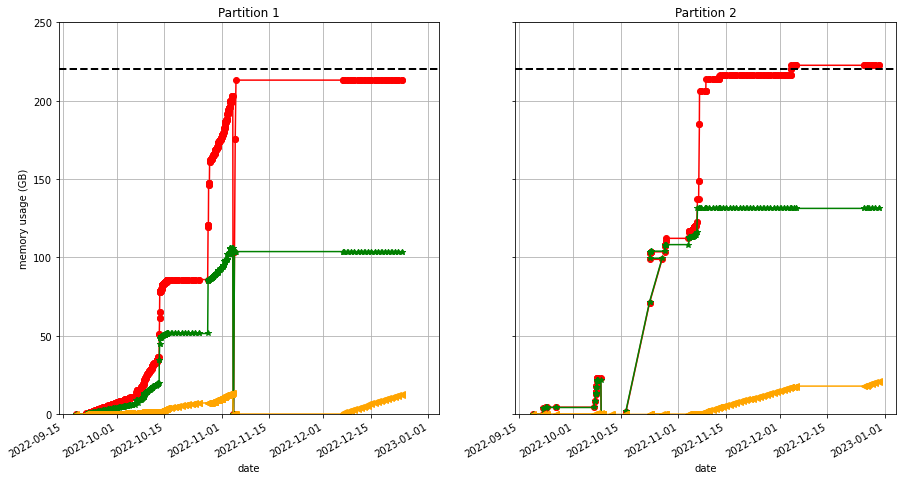

In [35]:
t0 = DT.fromisoformat('2022-11-06T11:30:00')
# t1 = t0 + TD(minutes=175) #36 datasets
i = 2

CM = PHI_MODE('HRT')
kw = CM.observation(t0,36,cadence=7,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = CM.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
# kw = CM.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = CM.packing(DT(2022,11,9,3,0,0),ndata=-1,level='raw',); PHI.saving(i,**kw)
CM, kw = flush_many([max_flush,max_flush],72,CM,DT(tF.year,tF.month,tF.day,17,0,0),ndata=-1,nbits=6,level='raw.pack',partition=i)
tF = CM.compr.pack.end + TD(days=1)

printp(CM,label='Crazy Mosaic, 36 datasets, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)


# <span style="color:blue">BRIGHT POINTS</span> <br>
6/11 (16:00 - 24:35)

flushing from 27/12 instead of 10/12

crop to 1024x1024, cadence 30m

Days needed: 1
Exceeding the number of datasets, ndata set to 25
Bright Points, no crop, proc
number of datasets: 25
cadence: 20 mins
duration: 8:35:00
amount of raw-data at 32 bits: 5531.3 MiB, 221.3 MiB per dataset
amount of crop-data at 32 bits: 3242.5 MiB, 129.7 MiB per dataset
cropping time: 0:19:29.987500
amount of pack-data at 16 bits: 1716.6 MiB, 68.7 MiB per dataset
packing time: 0:18:31.392825
compressing (+ flushing) time: 1:16:22.382400
amount of compressed data + metadata at 6 bits: 546.3 MiB, 21.9 MiB per dataset
amount of metadata:  600 MiB
amount of memory usage: 10490.4 MiB



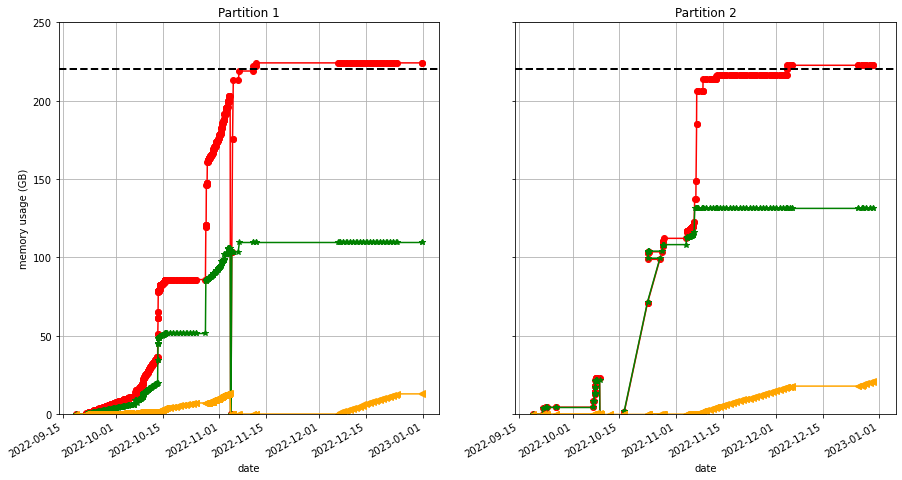

In [36]:
t0 = DT.fromisoformat('2022-11-06T16:00:00')
t1 = DT.fromisoformat('2022-11-07T00:35:00')
i = 1
crop = 1128

BP = PHI_MODE('HRT')
kw = BP.observation(t0,t1,cadence=20,shape=(2048,crop,4,6)); PHI.saving(i,**kw)
# kw = BP.cropping(t0,[1536,1536],ndata=-1,level='raw'); PHI.saving(i,**kw)
# kw = BP.packing(kw['end'],ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
# kw = BP.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

kw = BP.cropping(DT(2022,11,11,3,0,0),[crop,crop],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = BP.packing(DT(2022,11,12,3,0,0),ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
BP, kw = flush_many([max_flush,max_flush],21.9,BP,DT(tF.year,tF.month,tF.day,17,0,0),ndata=-1,nbits=6,level='raw.pack',partition=i)
tF = ARH.compr.pack.end + TD(days=1)

printp(BP,label='Bright Points, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)


# Final plots

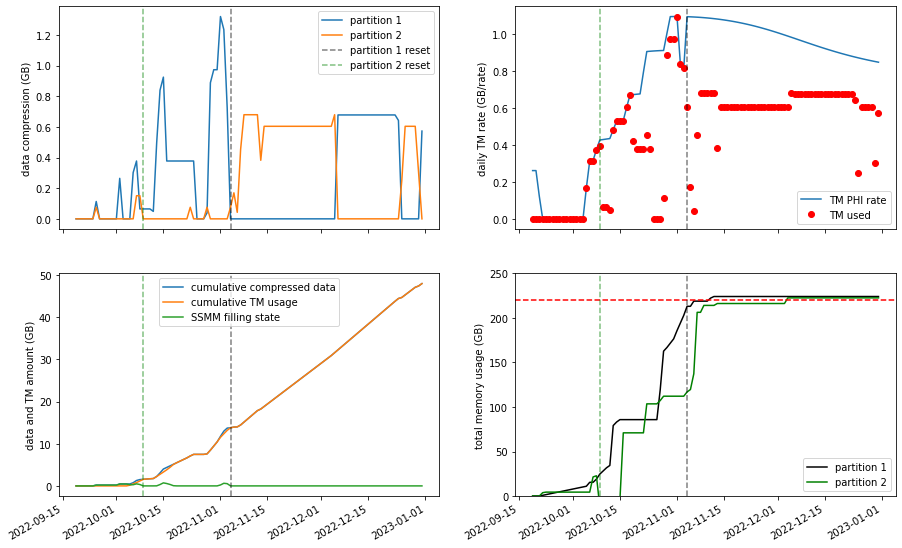

In [37]:
final_plot(PHI,TM)

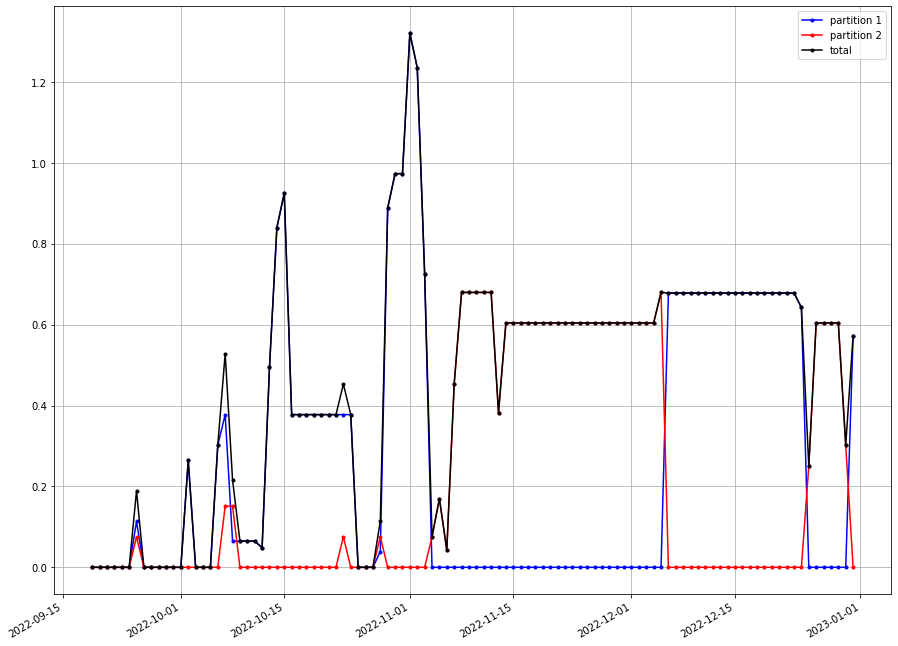

In [38]:
temp = PHI.part1.history    # plt.subplot(121)
c1 = np.asarray(PHI.part1.history['compr'])
c2 = np.asarray(PHI.part2.history['compr'])

d1 = np.asarray(PHI.part1.history['start'])
d2 = np.asarray(PHI.part2.history['start'])

starttime = min(d1[0],d2[0])
endtime = max(d1[-1],d2[-1])
t0 = starttime
times = []
while starttime.date() <= endtime.date():
    times.append(starttime.date())
    starttime += datetime.timedelta(days=1)
starttime = t0; del t0
times_float = [(t - d1[0]).total_seconds() for t in d1]
times = np.asarray(times)

newc1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc1[ind] += j/1e3
newc1 = np.asarray(newc1)

newc2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc2[ind] += j/1e3
newc2 = np.asarray(newc2)


plt.figure(figsize=(15,12))
plt.plot_date(times,newc1,color='blue',linestyle='-',marker='.',label='partition 1')
plt.plot_date(times,newc2,color='red',linestyle='-',marker='.',label='partition 2')
plt.plot_date(times,newc1+newc2,color='black',linestyle='-',marker='.',label='total')
plt.gcf().autofmt_xdate()
plt.grid()
plt.legend()


In [39]:
for i in range(0,np.size(newc1)):
    print(times[i],'\t',round((newc1[i]+newc2[i])*1e9/2**20,0))
# times[17]
# newc1[17]

2022-09-19 	 0.0
2022-09-20 	 0.0
2022-09-21 	 0.0
2022-09-22 	 0.0
2022-09-23 	 0.0
2022-09-24 	 0.0
2022-09-25 	 180.0
2022-09-26 	 0.0
2022-09-27 	 0.0
2022-09-28 	 0.0
2022-09-29 	 0.0
2022-09-30 	 0.0
2022-10-01 	 0.0
2022-10-02 	 252.0
2022-10-03 	 0.0
2022-10-04 	 0.0
2022-10-05 	 0.0
2022-10-06 	 288.0
2022-10-07 	 504.0
2022-10-08 	 206.0
2022-10-09 	 62.0
2022-10-10 	 62.0
2022-10-11 	 62.0
2022-10-12 	 46.0
2022-10-13 	 472.0
2022-10-14 	 801.0
2022-10-15 	 882.0
2022-10-16 	 360.0
2022-10-17 	 360.0
2022-10-18 	 360.0
2022-10-19 	 360.0
2022-10-20 	 360.0
2022-10-21 	 360.0
2022-10-22 	 360.0
2022-10-23 	 432.0
2022-10-24 	 360.0
2022-10-25 	 0.0
2022-10-26 	 0.0
2022-10-27 	 0.0
2022-10-28 	 109.0
2022-10-29 	 847.0
2022-10-30 	 928.0
2022-10-31 	 928.0
2022-11-01 	 1259.0
2022-11-02 	 1178.0
2022-11-03 	 692.0
2022-11-04 	 72.0
2022-11-05 	 162.0
2022-11-06 	 41.0
2022-11-07 	 432.0
2022-11-08 	 648.0
2022-11-09 	 648.0
2022-11-10 	 648.0
2022-11-11 	 648.0
2022-11-12 	 6

/tmp/ipykernel_260816/3875396231.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
/tmp/ipykernel_260816/3875396231.py:160: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)


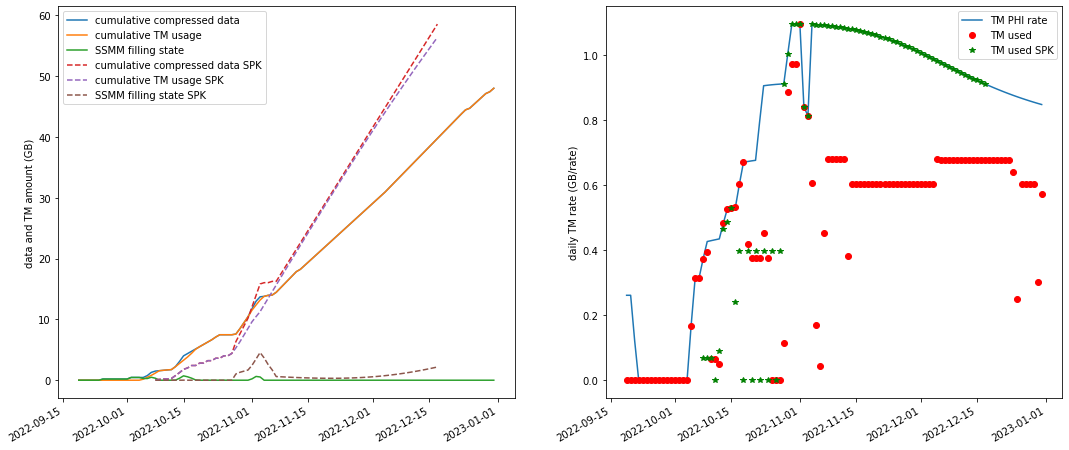

In [40]:
from scipy.interpolate import interp1d
tot1 = np.asarray(PHI.part1.history['occu'])
tot2 = np.asarray(PHI.part2.history['occu'])
c1 = np.asarray(PHI.part1.history['compr'])
c2 = np.asarray(PHI.part2.history['compr'])
d1 = np.asarray(PHI.part1.history['start'])
d2 = np.asarray(PHI.part2.history['start'])

starttime = min(d1[0],d2[0])
endtime = max(d1[-1],d2[-1])
t0 = starttime
times = []
while starttime.date() <= endtime.date():
    times.append(starttime.date())
    starttime += datetime.timedelta(days=1)
starttime = t0; del t0
times_float = [(t - d1[0]).total_seconds() for t in d1]
times = np.asarray(times)

s = np.argsort(d1)

newtot1 = np.zeros(np.size(times))
for i,j in zip(d1,tot1):
    if True:
        ind = np.where(times == i.date())[0]
        newtot1[ind] += j/1e3
newtot1 = np.asarray(newtot1)

newtot2 = np.zeros(np.size(times))
for i,j in zip(d2,tot2):
    if True:
        ind = np.where(times == i.date())[0]
        newtot2[ind] += j/1e3
newtot2 = np.asarray(newtot2)

newc1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc1[ind] += j/1e3
newc1 = np.asarray(newc1)


newc2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc2[ind] += j/1e3
newc2 = np.asarray(newc2)

form1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j<0:
        ind = np.where(times == i.date())[0]
        form1[ind] += j/1e3
form1 = np.asarray(form1)


form2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j<0:
        ind = np.where(times == i.date())[0]
        form2[ind] += j/1e3
form2 = np.asarray(form2)

trig1 = np.where(form1 < 0)[0]
trig2 = np.where(form2 < 0)[0]

x = TM['date'][np.logical_and(TM['date'] <= endtime+datetime.timedelta(days=1),TM['date'] >= starttime-datetime.timedelta(days=1))]
y = TM['tm_rate'][np.logical_and(TM['date'] <= endtime+datetime.timedelta(days=1),TM['date'] >= starttime-datetime.timedelta(days=1))]
z = TM['duration'][np.logical_and(TM['date'] <= endtime+datetime.timedelta(days=1),TM['date'] >= starttime-datetime.timedelta(days=1))]

xx = [(i - starttime).total_seconds() for i in x]
f = interp1d(xx, y*z)
xnew = [(i - starttime.date()).total_seconds() for i in times]
ynew = f(xnew)/8e9
ynew[times<datetime.date(2022,4,1)] *= .2
ynew[np.logical_and(times>=datetime.date(2022,4,1), times<datetime.date(2022,10,1))] *= .3
ynew[times>=datetime.date(2022,10,1)] *= .2

tm_used = np.zeros(times.size)
down = 0#np.zeros(times.size)
for i in range(times.size):
    if newc1[i] > 0 or newc2[i] > 0:
        tm_used[i] = min(ynew[i],np.sum(newc1[:i+1] + newc2[:i+1]) - tm_used[:i].sum())
        down = max(0,np.sum(newc1[:i+1] + newc2[:i+1] - tm_used[:i+1]))
    else:
        if down > 0:
            tm_used[i] = min(ynew[i],np.sum(newc1[:i+1] + newc2[:i+1]) - tm_used[:i].sum())
            down = max(0,np.sum(newc1[:i+1] + newc2[:i+1] - tm_used[:i+1]))


plt.figure(figsize=(18,8))
plt.subplot(122)
plt.ylabel('daily TM rate (GB/rate)')
plt.plot(times,ynew,label='TM PHI rate')
plt.plot(times,tm_used,'ro',label='TM used')
plt.legend()

plt.subplot(121)
plt.ylabel('data and TM amount (GB)')
plt.plot(times,np.cumsum(newc1+newc2),label='cumulative compressed data')
plt.plot(times,np.cumsum(tm_used),label='cumulative TM usage')
plt.plot(times,np.cumsum(newc1+newc2)-np.cumsum(tm_used),label='SSMM filling state')
# cond = np.logical_and(FL['date']>datetime.datetime(2022,1,19,0,0), FL['date']<datetime.datetime(2022,5,1,0,0))
# plt.plot(FL['date'][cond],-np.cumsum(FL['flush'][cond]*2**20/1e9),'m',label='SOOPK FLUSH')
plt.legend()

from scipy.interpolate import interp1d

temp = np.asarray([708,0,0,0,515,0,40,65,65,65,85,445,465,515,220,380,0,380,0,380,0,380,0,380,0,380,1850,1222,1222,1222,1788,1788,1788,203,0,205,0]+[1008]*40)*2**20/1e9

# final_plot(PHI,TM)
starttime = DT(2022,10,2,0,0,0)
endtime = DT(2022,12,17,0,0,0)
d1 = np.asarray(PHI.part1.history['start'])
d2 = np.asarray(PHI.part2.history['start'])

# starttime = min(d1[0],d2[0])
# endtime = max(d1[-1],d2[-1])
t0 = starttime
times = []
while starttime.date() <= endtime.date():
    times.append(starttime.date())
    starttime += datetime.timedelta(days=1)
starttime = t0; del t0
times_float = [(t - d1[0]).total_seconds() for t in d1]
times = np.asarray(times)

x = TM['date'][np.logical_and(TM['date'] <= endtime+datetime.timedelta(days=1),TM['date'] >= starttime-datetime.timedelta(days=1))]
y = TM['tm_rate'][np.logical_and(TM['date'] <= endtime+datetime.timedelta(days=1),TM['date'] >= starttime-datetime.timedelta(days=1))]
z = TM['duration'][np.logical_and(TM['date'] <= endtime+datetime.timedelta(days=1),TM['date'] >= starttime-datetime.timedelta(days=1))]

xx = [(i - starttime).total_seconds() for i in x]
f = interp1d(xx, y*z)
xnew = [(i - starttime.date()).total_seconds() for i in times]
ynew = f(xnew)/8e9
ynew[times<datetime.date(2022,4,1)] *= .2
ynew[np.logical_and(times>=datetime.date(2022,4,1), times<datetime.date(2022,10,1))] *= .3
ynew[times>=datetime.date(2022,10,1)] *= .2

tm_used = np.zeros(times.size)
down = 0#np.zeros(times.size)
for i in range(times.size):
    if temp[i] > 0:
        tm_used[i] = min(ynew[i],np.sum(temp[:i+1]) - tm_used[:i].sum())
        down = max(0,np.sum(temp[:i+1] - tm_used[:i+1]))
    else:
        if down > 0:
            tm_used[i] = min(ynew[i],np.sum(temp[:i+1]) - tm_used[:i].sum())
            down = max(0,np.sum(temp[:i+1]- tm_used[:i+1]))

plt.subplot(121)
plt.ylabel('data and TM amount (GB)')
plt.plot(times,np.cumsum(temp),'--',label='cumulative compressed data SPK')
plt.plot(times,np.cumsum(tm_used),'--',label='cumulative TM usage SPK')
plt.plot(times,np.cumsum(temp)-np.cumsum(tm_used),'--',label='SSMM filling state SPK')
plt.legend()

plt.subplot(122)
plt.ylabel('daily TM rate (GB/rate)')
# plt.plot(times,ynew,'--',label='TM PHI rate SPK')
plt.plot(times,tm_used,'g*',label='TM used SPK')
plt.legend()

plt.gcf().autofmt_xdate()

In [43]:
for i in range(0,np.size(temp)):
    print(times[i],'\t',round((temp[i])*1e9/2**20,0))

2022-10-08 	 65.0
2022-10-09 	 65.0
2022-10-10 	 65.0
2022-10-11 	 0.0
2022-10-12 	 85.0
2022-10-13 	 445.0
2022-10-14 	 465.0
2022-10-15 	 515.0
2022-10-16 	 220.0
2022-10-17 	 380.0
2022-10-18 	 0.0
2022-10-19 	 380.0
2022-10-20 	 0.0
2022-10-21 	 380.0
2022-10-22 	 0.0
2022-10-23 	 380.0
2022-10-24 	 0.0
2022-10-25 	 380.0
2022-10-26 	 0.0
2022-10-27 	 380.0
2022-10-28 	 1850.0
2022-10-29 	 1222.0
2022-10-30 	 1222.0
2022-10-31 	 1222.0
2022-11-01 	 1788.0
2022-11-02 	 1788.0
2022-11-03 	 1788.0
2022-11-04 	 203.0
2022-11-05 	 0.0
2022-11-06 	 205.0
2022-11-07 	 0.0
2022-11-08 	 1008.0
2022-11-09 	 1008.0
2022-11-10 	 1008.0
2022-11-11 	 1008.0
2022-11-12 	 1008.0
2022-11-13 	 1008.0
2022-11-14 	 1008.0
2022-11-15 	 1008.0
2022-11-16 	 1008.0
2022-11-17 	 1008.0
2022-11-18 	 1008.0
2022-11-19 	 1008.0
2022-11-20 	 1008.0
2022-11-21 	 1008.0
2022-11-22 	 1008.0
2022-11-23 	 1008.0
2022-11-24 	 1008.0
2022-11-25 	 1008.0
2022-11-26 	 1008.0
2022-11-27 	 1008.0
2022-11-28 	 1008.0
2022